In [1]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as sps # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)
from scipy.stats import ttest_rel, f_oneway,ttest_1samp
from dataset import *

from statsmodels.stats.anova import AnovaRM # perform F test

In [2]:
# setting directories
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/cifs/diedrichsen/data/FunctionalFusion'
atlas_dir = base_dir + '/Atlases'


language_dir = '/srv/diedrichsen/data/Cerebellum/Language'
if not Path(language_dir).exists():
    language_dir = '/cifs/diedrichsen/data/Cerebellum/Language'
if not Path(language_dir).exists:
    language_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Language'

In [3]:
# Functions
# prepare dataframe for plotting
def prep_df(dataframe, agg_kw = {}, groupby = "cond_name"):
    """
    prepare the region dataframe to do the scatter plot
    gets the mean across subjects (data point) and std of residuals
    Args:
        dataframe (pd.DataFrame) - dataframe with residuals info 
        agg_kw (dict) - dictionary determining info for dataframe aggregation

    Returns:
    g_df (pd.DataFrame) - dataframe ready for putting into the scatterplot function
    """
    # group by condition
    grouped = dataframe.groupby([groupby])
    g_df = grouped.agg(agg_kw)
    
    g_std = grouped.std(numeric_only=True)
    g_df["Y_CI"] = grouped.Y.apply(sps.sem) * 1.96
    g_df["X_CI"] = grouped.X.apply(sps.sem)*1.96
    g_df['err'] = g_std['res']
    
    return g_df


# plotting:
def make_plot(dataframe, hue = "cond_name", style = "cond_name", height = 4, aspect = 1):
    """
    make scatterplot
    uses FacetGrid 
    Args: 
    dataframe (pd.DataFrame) - output from prep_df
    hue (str)      - column name to be used to determine color
    style (str)    - column name to be used to determine shape of the marker
    label (str)    - column name to be used to determine the label of the data points
    height (int)   - int to determine the height of the plot
    aspect (float) - floating number to determine the aspect ratio of the plot
    """
    g = sns.FacetGrid(dataframe,  height=height, aspect=aspect)
    # do the scatter plot
    g.map_dataframe(sns.scatterplot, x="X", y="Y", 
                                    style = style, hue = hue, s = 50)
    g.add_legend()

    # fit the regression on top of the scatterplot
    g.map_dataframe(sns.regplot, x="X", y="Y", 
                        fit_reg=True, 
                        scatter_kws={"s": 0}, # size is set to 0 so that it doesn't cover the markers created in the scatterplot step 
                        line_kws={'label':"Linear Reg", "color": 'grey'})

    # put the errorbars in 
    g.map(plt.errorbar, x = df_preped['X'], 
                        y = df_preped['Y'], 
                        yerr = df_preped['err'],
                        elinewidth=1, 
                        fmt='none', # no marker will be used when plotting the error bars
                        color='grey', 
                        ecolor='0.9'
                )
    # set labels
    g.set_xlabels('Cortical Activation (a.u.)')
    g.set_ylabels('Cerebellar Activation (a.u.)')


In [27]:
# load the dataframe for the whole 
df_path = os.path.join(language_dir, "IBC/whole", "whole_ses-rsvplanguage.tsv")
df = pd.read_csv(df_path, sep="\t")
df_averaged = df.groupby(['sn', 'cond_name']).mean()
df_averaged = df_averaged.drop(columns=['half','res','coef','R2'])
df_averaged = df_averaged.reset_index()


print(df_averaged)

        sn         cond_name  cond_num_uni  n_rep  Unnamed: 0  reg_id  \
0   sub-01  complex_sentence         190.0    1.0        31.5     1.0   
1   sub-01  consonant_string         191.0    1.0        32.5     2.0   
2   sub-01       jabberwocky         192.0    1.0        33.5     3.0   
3   sub-01             probe         193.0    1.0        34.5     4.0   
4   sub-01   pseudoword_list         194.0    1.0        35.5     5.0   
..     ...               ...           ...    ...         ...     ...   
79  sub-15       jabberwocky         192.0    1.0        33.5     3.0   
80  sub-15             probe         193.0    1.0        34.5     4.0   
81  sub-15   pseudoword_list         194.0    1.0        35.5     5.0   
82  sub-15   simple_sentence         195.0    1.0        36.5     6.0   
83  sub-15         word_list         196.0    1.0        37.5     7.0   

           X         Y  label  
0  -0.107489 -0.078778    1.0  
1  -0.080986 -0.062907    1.0  
2  -0.122244 -0.083608    1

/tmp/ipykernel_50840/1158164050.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged = df.groupby(['sn', 'cond_name']).mean()


/tmp/ipykernel_50840/3647883168.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in sn_groups:


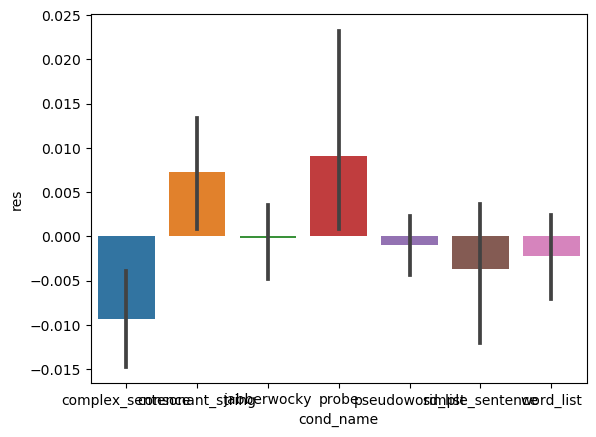

In [35]:
df_residuals = df_averaged.copy()

#create new columns to store the slope and intercept
df_residuals['slope'] = np.nan
df_residuals['intercept'] = np.nan

#group the dataframe by sn
sn_groups = df_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    df_residuals.loc[df_residuals['sn'] == name, 'slope'] = slope
    df_residuals.loc[df_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in df_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    df_residuals.loc[index, 'Y_pred'] = Y_pred
    df_residuals.loc[index, 'res'] = res

sns.barplot(data=df_residuals,x='cond_name',y='res')

In [ ]:
# prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_averaged, groupby = "cond_name", agg_kw=agg_kw)


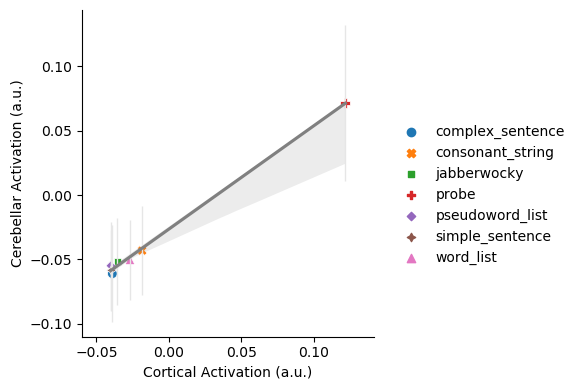

In [34]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [27]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=conditions_df, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  2.1502 6.0000 66.0000 0.0591



# Investigate further through ttests

complex_sentence > jabberwocky:

In [29]:
#prep dataframe/table for ttest
D1 = df.loc[(df['cond_name']== 'complex_sentence') | (df['cond_name']== 'jabberwocky')]
dd1= pd.pivot_table(D1, values = 'res', index = 'sn', columns = ['cond_name'], aggfunc= np.mean)

#ttest
t,p=ttest_rel(dd1.complex_sentence,dd1.jabberwocky)
print(f'ttest between complex_sentence and jaberwocky, t = {t} and p={p}')

#1samp
t1,p1=ttest_1samp(dd1.complex_sentence,0)
print(f'1samp ttest complex_sentence t is{t1} and p is{p1}')

t2,p2=ttest_1samp(dd1.jabberwocky,0)
print(f'1samp ttest jabberwocky t is{t2} and p is{p2}')


ttest between complex_sentence and jaberwocky, t = -2.9744949011544213 and p=0.012643335177323127
1samp ttest complex_sentence t is-2.9513774707956033 and p is0.01317689691655718
1samp ttest jabberwocky t is0.2899252540062735 and p is0.7772656172293068


complex_sentence > simple_sentence:

In [12]:
#prep dataframe/table for ttest
D1 = df.loc[(df['cond_name']== 'complex_sentence') | (df['cond_name']== 'simple_sentence')]
dd1= pd.pivot_table(D1, values = 'res', index = 'sn', columns = ['cond_name'], aggfunc= np.mean)

#ttest
t,p=ttest_rel(dd1.complex_sentence,dd1.simple_sentence)
print(f'ttest between complex_sentence and simple_sentence, t = {t} and p={p}')

ttest between complex_sentence and simple_sentence, t = -0.8780437423411154 and p=0.39869268371657507


word_list > pseudoword_list:

In [30]:
#prep dataframe/table for ttest
D1 = df.loc[(df['cond_name']== 'word_list') | (df['cond_name']== 'pseudoword_list')]
dd1= pd.pivot_table(D1, values = 'res', index = 'sn', columns = ['cond_name'], aggfunc= np.mean)

#ttest
t,p=ttest_rel(dd1.word_list,dd1.pseudoword_list)
print(f'ttest between word_list and pseudoword_list, t = {t} and p={p}')

#1samp
t1,p1=ttest_1samp(dd1.word_list,0)
print(f'1samp ttest word_list t is{t1} and p is{p1}')

t2,p2=ttest_1samp(dd1.pseudoword_list,0)
print(f'1samp ttest pseudoword_list t is{t2} and p is{p2}')

ttest between word_list and pseudoword_list, t = -1.718737719067507 and p=0.11364036959030252
1samp ttest word_list t is-1.495258182448424 and p is0.1629727685804352
1samp ttest pseudoword_list t is-0.43745448499480555 and p is0.6702465580110808


word_list > consonant_string:

In [31]:
#prep dataframe/table for ttest
D1 = df.loc[(df['cond_name']== 'word_list') | (df['cond_name']== 'consonant_string')]
dd1= pd.pivot_table(D1, values = 'res', index = 'sn', columns = ['cond_name'], aggfunc= np.mean)

#ttest
t,p=ttest_rel(dd1.word_list,dd1.consonant_string)
print(f'ttest between word_list and consonant_string, t = {t} and p={p}')

ttest between word_list and consonant_string, t = -1.3336899006112497 and p=0.2092630636285431


simple_sentence > word_list:

In [32]:
#prep dataframe/table for ttest
D1 = df.loc[(df['cond_name']== 'word_list') | (df['cond_name']== 'simple_sentence')]
dd1= pd.pivot_table(D1, values = 'res', index = 'sn', columns = ['cond_name'], aggfunc= np.mean)

#ttest
t,p=ttest_rel(dd1.word_list,dd1.simple_sentence)
print(f'ttest between word_list and simple_sentence, t = {t} and p={p}')

ttest between word_list and simple_sentence, t = -0.03550986910786334 and p=0.972309377930969
